In [1]:
from prep_vis import *

In [80]:
import random
from torch import FloatTensor
from albumentations import (HorizontalFlip, Blur, GaussNoise, RandomCrop, RandomContrast, BboxParams, Rotate, Compose)
from albumentations.pytorch import ToTensor
import numpy as np
from torchvision.transforms import ToPILImage

class Aug_Wrap():
    def __init__(self, alb_aug):
        self.aug = alb_aug
        
    def __call__(self, i, t):
        dic = {}
        dic['image'] = np.asarray(i).astype('uint8')#np.moveaxis(np.asarray(i), 0, 1)
        dic['bboxes'] = t['boxes']
        dic['labels'] = t['labels']
        augmented = self.aug(**dic)
        i = augmented['image']
        t['boxes'] = FloatTensor(np.array(augmented['bboxes']))
        t['labels'] = LongTensor(augmented['labels'])
        return i, t

def get_aug(min_area=0., min_visibility=0., train=True):
    aug_test = [ToTensor()]
    aug = [HorizontalFlip(p=0.5), Blur(p=0.5),
           GaussNoise(p = 0.5),
           RandomCrop(height = random.randint(350, 480), width = random.randint(500, 640), p = 0.5),
           RandomContrast(p = 0.5),
           Rotate(p = 0.5, limit = 10),
           ToTensor()]
    if train:
        comp = Compose(aug, bbox_params=BboxParams(format='pascal_voc',
                                                   min_area=min_area,
                                                   min_visibility=min_visibility,
                                                   label_fields=['labels']))
        return Aug_Wrap(comp)
    else:
        comp =  Compose(aug_test, bbox_params=BboxParams(format='pascal_voc',
                                                         min_area=min_area,
                                                         min_visibility=min_visibility,
                                                         label_fields=['labels']))
        return Aug_Wrap(comp)


In [81]:
train = CocoDetection_(root = "images",
                       annFile = "train.json",
                       transforms=get_aug())

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


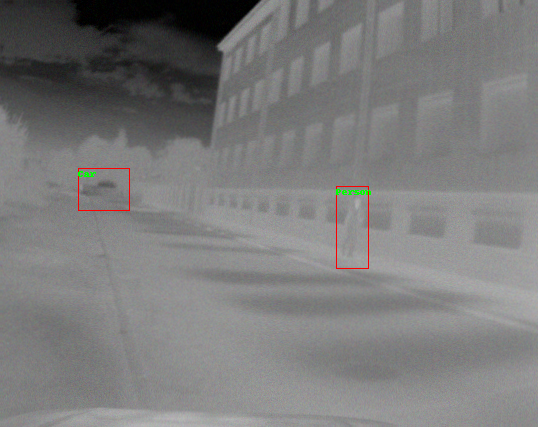

In [82]:
visualize_boxes(train[0])

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


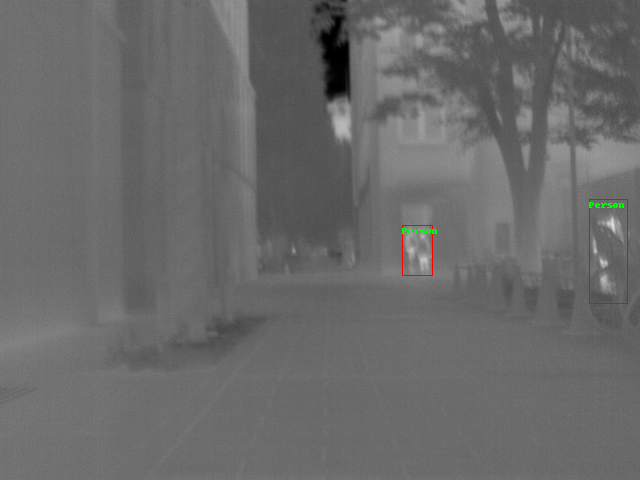

In [140]:
train = Pretrain(root = "fir",
                 annFile = "train_fir.json",
                 transforms=get_aug(train=False))
visualize_boxes(train[101])

In [100]:
import torch
import torchvision
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device('cuda:2')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
model.to(device)
model.load_state_dict(torch.load("model_pretrained", map_location='cuda:2'))

<All keys matched successfully>

In [96]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
import torch
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)
#device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [101]:
# use our dataset and defined transformations
dataset = CocoDetection_(root="images", annFile="train.json",
                         transforms=get_aug(train=True))
dataset_test = CocoDetection_(root="images", annFile="train.json",
                              transforms=get_aug(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [102]:
#device = torch.device('cuda:1') #if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

#model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [88]:
dataset[0]

(tensor([[[0.1686, 0.1686, 0.1608,  ..., 0.0824, 0.0784, 0.0941],
          [0.1608, 0.1608, 0.1529,  ..., 0.1059, 0.1176, 0.1412],
          [0.1569, 0.1569, 0.1529,  ..., 0.1686, 0.1765, 0.1922],
          ...,
          [0.6510, 0.6510, 0.6510,  ..., 0.6157, 0.6118, 0.6157],
          [0.6549, 0.6549, 0.6549,  ..., 0.6078, 0.6118, 0.6157],
          [0.6510, 0.6510, 0.6549,  ..., 0.6078, 0.6118, 0.6157]],
 
         [[0.1686, 0.1686, 0.1608,  ..., 0.0824, 0.0784, 0.0941],
          [0.1608, 0.1608, 0.1529,  ..., 0.1059, 0.1176, 0.1412],
          [0.1569, 0.1569, 0.1529,  ..., 0.1686, 0.1765, 0.1922],
          ...,
          [0.6510, 0.6510, 0.6510,  ..., 0.6157, 0.6118, 0.6157],
          [0.6549, 0.6549, 0.6549,  ..., 0.6078, 0.6118, 0.6157],
          [0.6510, 0.6510, 0.6549,  ..., 0.6078, 0.6118, 0.6157]],
 
         [[0.1686, 0.1686, 0.1608,  ..., 0.0824, 0.0784, 0.0941],
          [0.1608, 0.1608, 0.1529,  ..., 0.1059, 0.1176, 0.1412],
          [0.1569, 0.1569, 0.1529,  ...,

In [103]:
num_epochs = 10

for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
        # update the learning rate
    lr_scheduler.step()
        # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/182]  eta: 0:02:14  lr: 0.000033  loss: 1.7338 (1.7338)  loss_classifier: 0.6753 (0.6753)  loss_box_reg: 0.1163 (0.1163)  loss_objectness: 0.8653 (0.8653)  loss_rpn_box_reg: 0.0769 (0.0769)  time: 0.7406  data: 0.3783  max mem: 0
Epoch: [0]  [ 10/182]  eta: 0:00:41  lr: 0.000309  loss: 0.7528 (0.9024)  loss_classifier: 0.2904 (0.3364)  loss_box_reg: 0.1460 (0.1381)  loss_objectness: 0.0674 (0.3652)  loss_rpn_box_reg: 0.0359 (0.0626)  time: 0.2425  data: 0.0406  max mem: 0
Epoch: [0]  [ 20/182]  eta: 0:00:35  lr: 0.000585  loss: 0.3734 (0.6258)  loss_classifier: 0.1968 (0.2541)  loss_box_reg: 0.0944 (0.1214)  loss_objectness: 0.0217 (0.2024)  loss_rpn_box_reg: 0.0304 (0.0478)  time: 0.1924  data: 0.0070  max mem: 0
Epoch: [0]  [ 30/182]  eta: 0:00:31  lr: 0.000860  loss: 0.3472 (0.5443)  loss_classifier: 0.1786 (0.2380)  loss_box_reg: 0.1080 (0.1230)  loss_objectness: 0.0159 (0.1442)  loss_rpn_box_reg: 0.0217 (0.0390)  time: 0.1918  data: 0.0070  max mem: 0
Epoch: [0]  

Epoch: [1]  [ 80/182]  eta: 0:00:20  lr: 0.005000  loss: 0.2451 (0.3051)  loss_classifier: 0.1043 (0.1324)  loss_box_reg: 0.0924 (0.0947)  loss_objectness: 0.0256 (0.0369)  loss_rpn_box_reg: 0.0217 (0.0410)  time: 0.2002  data: 0.0072  max mem: 0
Epoch: [1]  [ 90/182]  eta: 0:00:18  lr: 0.005000  loss: 0.2106 (0.3052)  loss_classifier: 0.1122 (0.1308)  loss_box_reg: 0.0661 (0.0945)  loss_objectness: 0.0190 (0.0371)  loss_rpn_box_reg: 0.0146 (0.0428)  time: 0.2011  data: 0.0071  max mem: 0
Epoch: [1]  [100/182]  eta: 0:00:16  lr: 0.005000  loss: 0.2864 (0.3061)  loss_classifier: 0.1149 (0.1298)  loss_box_reg: 0.0661 (0.0931)  loss_objectness: 0.0246 (0.0385)  loss_rpn_box_reg: 0.0409 (0.0447)  time: 0.1985  data: 0.0068  max mem: 0
Epoch: [1]  [110/182]  eta: 0:00:14  lr: 0.005000  loss: 0.2264 (0.3019)  loss_classifier: 0.0960 (0.1273)  loss_box_reg: 0.0626 (0.0913)  loss_objectness: 0.0310 (0.0377)  loss_rpn_box_reg: 0.0268 (0.0455)  time: 0.1973  data: 0.0068  max mem: 0
Epoch: [1]  

Epoch: [2]  [160/182]  eta: 0:00:04  lr: 0.005000  loss: 0.2429 (0.2968)  loss_classifier: 0.0887 (0.1285)  loss_box_reg: 0.0909 (0.0946)  loss_objectness: 0.0140 (0.0329)  loss_rpn_box_reg: 0.0275 (0.0408)  time: 0.1925  data: 0.0069  max mem: 0
Epoch: [2]  [170/182]  eta: 0:00:02  lr: 0.005000  loss: 0.2819 (0.2995)  loss_classifier: 0.1085 (0.1287)  loss_box_reg: 0.0781 (0.0956)  loss_objectness: 0.0246 (0.0330)  loss_rpn_box_reg: 0.0328 (0.0423)  time: 0.1931  data: 0.0070  max mem: 0
Epoch: [2]  [180/182]  eta: 0:00:00  lr: 0.005000  loss: 0.2852 (0.2991)  loss_classifier: 0.1085 (0.1288)  loss_box_reg: 0.0729 (0.0948)  loss_objectness: 0.0280 (0.0327)  loss_rpn_box_reg: 0.0378 (0.0428)  time: 0.1921  data: 0.0068  max mem: 0
Epoch: [2]  [181/182]  eta: 0:00:00  lr: 0.005000  loss: 0.2852 (0.2989)  loss_classifier: 0.1108 (0.1291)  loss_box_reg: 0.0729 (0.0946)  loss_objectness: 0.0271 (0.0326)  loss_rpn_box_reg: 0.0328 (0.0426)  time: 0.1878  data: 0.0068  max mem: 0
Epoch: [2] T

Epoch: [4]  [  0/182]  eta: 0:01:42  lr: 0.000500  loss: 0.2726 (0.2726)  loss_classifier: 0.0617 (0.0617)  loss_box_reg: 0.0507 (0.0507)  loss_objectness: 0.0244 (0.0244)  loss_rpn_box_reg: 0.1357 (0.1357)  time: 0.5622  data: 0.3544  max mem: 0
Epoch: [4]  [ 10/182]  eta: 0:00:38  lr: 0.000500  loss: 0.2726 (0.2892)  loss_classifier: 0.0960 (0.1204)  loss_box_reg: 0.0803 (0.0821)  loss_objectness: 0.0244 (0.0242)  loss_rpn_box_reg: 0.0317 (0.0624)  time: 0.2265  data: 0.0372  max mem: 0
Epoch: [4]  [ 20/182]  eta: 0:00:33  lr: 0.000500  loss: 0.2002 (0.2627)  loss_classifier: 0.0927 (0.1141)  loss_box_reg: 0.0668 (0.0816)  loss_objectness: 0.0145 (0.0216)  loss_rpn_box_reg: 0.0300 (0.0454)  time: 0.1919  data: 0.0059  max mem: 0
Epoch: [4]  [ 30/182]  eta: 0:00:31  lr: 0.000500  loss: 0.1632 (0.2599)  loss_classifier: 0.0770 (0.1119)  loss_box_reg: 0.0543 (0.0820)  loss_objectness: 0.0145 (0.0222)  loss_rpn_box_reg: 0.0151 (0.0439)  time: 0.1930  data: 0.0064  max mem: 0
Epoch: [4]  

Epoch: [5]  [ 80/182]  eta: 0:00:20  lr: 0.000500  loss: 0.2052 (0.2344)  loss_classifier: 0.0825 (0.1018)  loss_box_reg: 0.0685 (0.0831)  loss_objectness: 0.0096 (0.0164)  loss_rpn_box_reg: 0.0268 (0.0332)  time: 0.1940  data: 0.0067  max mem: 0
Epoch: [5]  [ 90/182]  eta: 0:00:18  lr: 0.000500  loss: 0.1942 (0.2333)  loss_classifier: 0.0864 (0.1017)  loss_box_reg: 0.0685 (0.0837)  loss_objectness: 0.0115 (0.0162)  loss_rpn_box_reg: 0.0169 (0.0317)  time: 0.1935  data: 0.0069  max mem: 0
Epoch: [5]  [100/182]  eta: 0:00:16  lr: 0.000500  loss: 0.1942 (0.2313)  loss_classifier: 0.0813 (0.0999)  loss_box_reg: 0.0663 (0.0819)  loss_objectness: 0.0104 (0.0153)  loss_rpn_box_reg: 0.0169 (0.0342)  time: 0.1933  data: 0.0071  max mem: 0
Epoch: [5]  [110/182]  eta: 0:00:14  lr: 0.000500  loss: 0.1763 (0.2264)  loss_classifier: 0.0779 (0.0978)  loss_box_reg: 0.0587 (0.0798)  loss_objectness: 0.0076 (0.0149)  loss_rpn_box_reg: 0.0200 (0.0339)  time: 0.1922  data: 0.0068  max mem: 0
Epoch: [5]  

Epoch: [6]  [160/182]  eta: 0:00:04  lr: 0.000050  loss: 0.1760 (0.2228)  loss_classifier: 0.0724 (0.0978)  loss_box_reg: 0.0557 (0.0785)  loss_objectness: 0.0096 (0.0136)  loss_rpn_box_reg: 0.0173 (0.0329)  time: 0.1928  data: 0.0067  max mem: 0
Epoch: [6]  [170/182]  eta: 0:00:02  lr: 0.000050  loss: 0.1720 (0.2210)  loss_classifier: 0.0728 (0.0972)  loss_box_reg: 0.0672 (0.0784)  loss_objectness: 0.0089 (0.0134)  loss_rpn_box_reg: 0.0162 (0.0321)  time: 0.1931  data: 0.0069  max mem: 0
Epoch: [6]  [180/182]  eta: 0:00:00  lr: 0.000050  loss: 0.1823 (0.2243)  loss_classifier: 0.0752 (0.0985)  loss_box_reg: 0.0678 (0.0791)  loss_objectness: 0.0112 (0.0145)  loss_rpn_box_reg: 0.0209 (0.0322)  time: 0.1952  data: 0.0067  max mem: 0
Epoch: [6]  [181/182]  eta: 0:00:00  lr: 0.000050  loss: 0.1823 (0.2243)  loss_classifier: 0.0752 (0.0987)  loss_box_reg: 0.0678 (0.0790)  loss_objectness: 0.0072 (0.0145)  loss_rpn_box_reg: 0.0162 (0.0321)  time: 0.1907  data: 0.0066  max mem: 0
Epoch: [6] T

Epoch: [8]  [  0/182]  eta: 0:01:36  lr: 0.000050  loss: 0.2308 (0.2308)  loss_classifier: 0.0915 (0.0915)  loss_box_reg: 0.0918 (0.0918)  loss_objectness: 0.0098 (0.0098)  loss_rpn_box_reg: 0.0378 (0.0378)  time: 0.5311  data: 0.3189  max mem: 0
Epoch: [8]  [ 10/182]  eta: 0:00:37  lr: 0.000050  loss: 0.2308 (0.2481)  loss_classifier: 0.0915 (0.0911)  loss_box_reg: 0.0807 (0.0864)  loss_objectness: 0.0098 (0.0139)  loss_rpn_box_reg: 0.0350 (0.0567)  time: 0.2208  data: 0.0350  max mem: 0
Epoch: [8]  [ 20/182]  eta: 0:00:33  lr: 0.000050  loss: 0.2222 (0.2406)  loss_classifier: 0.0857 (0.0945)  loss_box_reg: 0.0695 (0.0842)  loss_objectness: 0.0089 (0.0175)  loss_rpn_box_reg: 0.0216 (0.0444)  time: 0.1902  data: 0.0065  max mem: 0
Epoch: [8]  [ 30/182]  eta: 0:00:30  lr: 0.000050  loss: 0.1846 (0.2374)  loss_classifier: 0.0906 (0.1009)  loss_box_reg: 0.0695 (0.0817)  loss_objectness: 0.0103 (0.0167)  loss_rpn_box_reg: 0.0216 (0.0382)  time: 0.1907  data: 0.0067  max mem: 0
Epoch: [8]  

Epoch: [9]  [ 80/182]  eta: 0:00:20  lr: 0.000005  loss: 0.2248 (0.2266)  loss_classifier: 0.0922 (0.0999)  loss_box_reg: 0.0782 (0.0808)  loss_objectness: 0.0078 (0.0136)  loss_rpn_box_reg: 0.0260 (0.0324)  time: 0.1917  data: 0.0068  max mem: 0
Epoch: [9]  [ 90/182]  eta: 0:00:18  lr: 0.000005  loss: 0.2248 (0.2266)  loss_classifier: 0.0931 (0.1008)  loss_box_reg: 0.0750 (0.0803)  loss_objectness: 0.0089 (0.0142)  loss_rpn_box_reg: 0.0220 (0.0313)  time: 0.1944  data: 0.0073  max mem: 0
Epoch: [9]  [100/182]  eta: 0:00:16  lr: 0.000005  loss: 0.2206 (0.2235)  loss_classifier: 0.0931 (0.0990)  loss_box_reg: 0.0749 (0.0794)  loss_objectness: 0.0089 (0.0139)  loss_rpn_box_reg: 0.0200 (0.0312)  time: 0.1946  data: 0.0071  max mem: 0
Epoch: [9]  [110/182]  eta: 0:00:14  lr: 0.000005  loss: 0.1870 (0.2235)  loss_classifier: 0.0842 (0.0998)  loss_box_reg: 0.0710 (0.0797)  loss_objectness: 0.0090 (0.0141)  loss_rpn_box_reg: 0.0129 (0.0298)  time: 0.1954  data: 0.0066  max mem: 0
Epoch: [9]  

In [107]:
torch.save(model.state_dict(), "model_trained")

In [ ]:
device

In [132]:
evaluate(model, data_loader_test, device=device)

Test:  [ 0/50]  eta: 0:00:16  model_time: 0.0594 (0.0594)  evaluator_time: 0.0028 (0.0028)  time: 0.3333  data: 0.2626  max mem: 0
Test:  [49/50]  eta: 0:00:00  model_time: 0.0365 (0.0376)  evaluator_time: 0.0029 (0.0044)  time: 0.0457  data: 0.0033  max mem: 0
Test: Total time: 0:00:02 (0.0549 s / it)
Averaged stats: model_time: 0.0365 (0.0376)  evaluator_time: 0.0029 (0.0044)
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.360
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.740
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.326
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.630
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]

In [104]:

test = Test(root="images",
            annFile="test_info.json",
            transforms=get_transform(train=False))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [130]:
model.eval()
preds = []
with torch.no_grad():
    for image, id in test:
        outputs = model([image.to(device)])
        outputs = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in outputs]
        preds.append((id, outputs[0]))
    #torch.cuda.empty_cache()

In [131]:
def get_bbox(bbox):
    return [bbox[0], bbox[1], bbox[2] - bbox[0], bbox[3] - bbox[1]]
with open('output_thresh.json', "w") as f:
    f.write("[")
    for id, out in preds:
        out['scores'] = out['scores'].numpy()        
        l = out['scores'] > 0.5
        
        out['scores'] = out['scores'][l]
        out['boxes'] = out['boxes'].numpy()[l]
        out['labels'] = out['labels'].numpy()[l]    
        for k in range(len(out['labels'])):
            f.write('{"image_id": ' + str(id) + ", ")
            f.write('"category_id": ' + str(out['labels'][k]) + ", ")
            f.write('"bbox": ' + str(get_bbox(out['boxes'][k])) + ", ")
            f.write('"score": ' + str(out['scores'][k]) + "}, ")
    f.seek(f.tell() - 2, os.SEEK_SET)
    f.write(']')
    

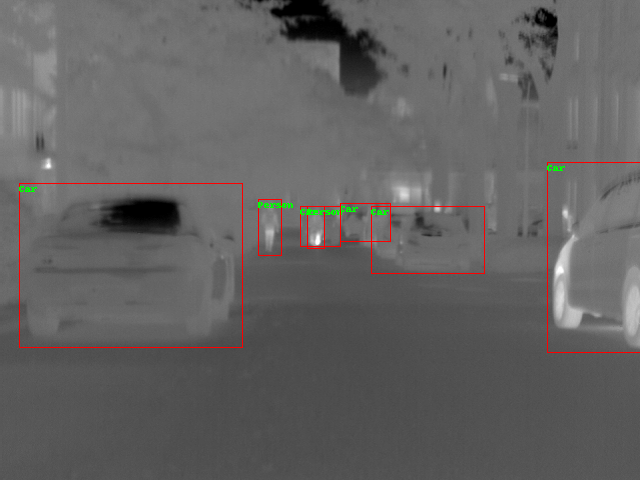

In [185]:
image, _ = train[995]
outputs = model([image.to(device)])
outputs = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in outputs]
visualize_boxes((image, outputs[0]), 7)

In [180]:
for i in train.ids:
    if train.coco.loadImgs(i)[0]['file_name'] == '006769.png':
        print(i)

995


7519